Task 1: Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [30]:
# Load the dataset
df = pd.read_csv('monthly_milk_production.csv')

In [31]:
print("Dataset shape:", df.shape)
print(df.head())
print(df.info())

Dataset shape: (168, 2)
      Date  Production
0  1962-01         589
1  1962-02         561
2  1962-03         640
3  1962-04         656
4  1962-05         727
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB
None


In [4]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Check basic statistics
print(df.describe())

Missing values in each column:
Date          0
Production    0
dtype: int64
       Production
count  168.000000
mean   754.708333
std    102.204524
min    553.000000
25%    677.750000
50%    761.000000
75%    824.500000
max    969.000000


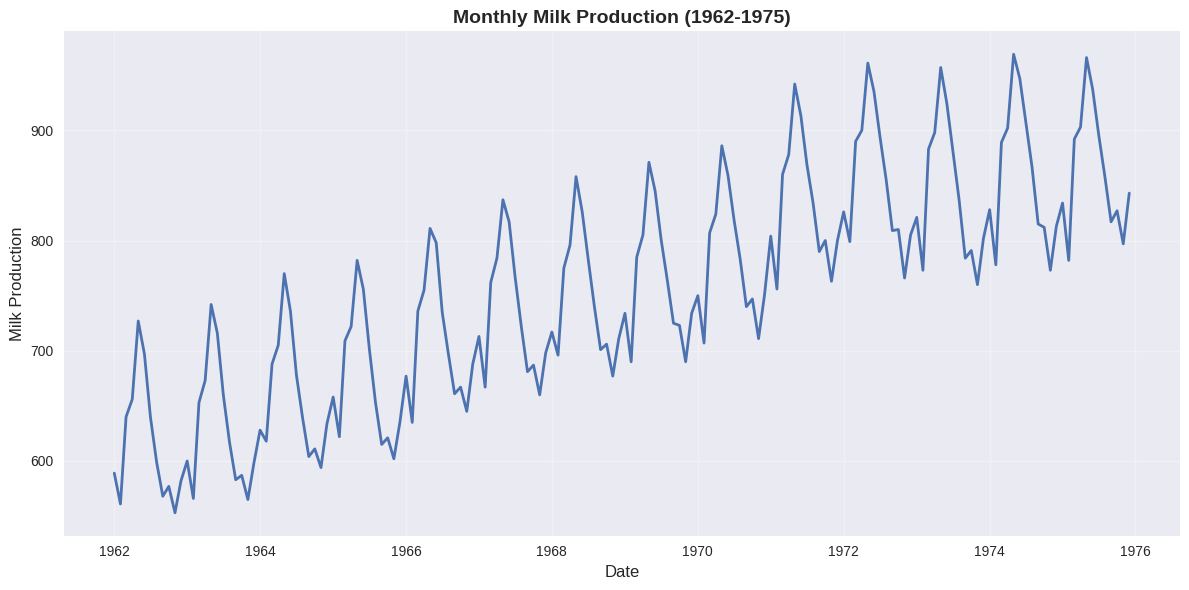

In [5]:
# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Plot the original time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Production'], linewidth=2)
plt.title('Monthly Milk Production (1962-1975)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Milk Production', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

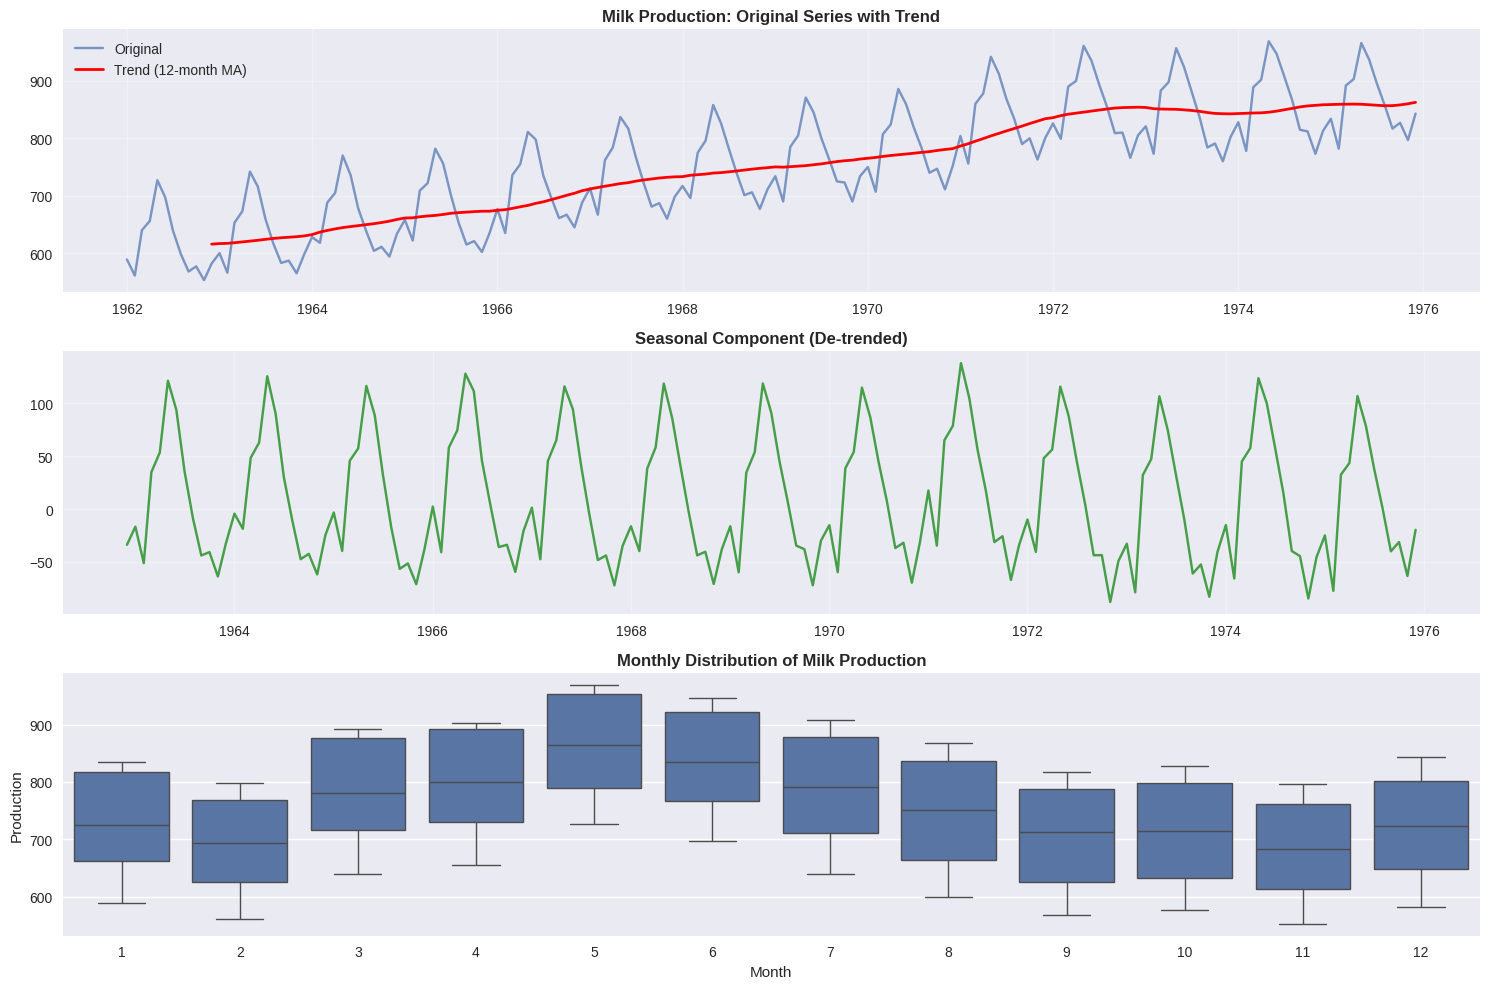

In [6]:
# Seasonal decomposition using moving averages
# Trend component (12-month moving average)
df['Trend'] = df['Production'].rolling(window=12).mean()

# Seasonal component (de-trended)
df['Seasonal'] = df['Production'] - df['Trend']

plt.figure(figsize=(15, 10))

# Original series with trend
plt.subplot(3, 1, 1)
plt.plot(df.index, df['Production'], label='Original', alpha=0.7)
plt.plot(df.index, df['Trend'], label='Trend (12-month MA)', linewidth=2, color='red')
plt.title('Milk Production: Original Series with Trend', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Seasonal component
plt.subplot(3, 1, 2)
plt.plot(df.index, df['Seasonal'], color='green', alpha=0.7)
plt.title('Seasonal Component (De-trended)', fontweight='bold')
plt.grid(True, alpha=0.3)

# Monthly boxplot to see seasonal patterns
plt.subplot(3, 1, 3)
df['Month'] = df.index.month
sns.boxplot(x='Month', y='Production', data=df)
plt.title('Monthly Distribution of Milk Production', fontweight='bold')
plt.tight_layout()
plt.show()

In [7]:
# Check for outliers using IQR method
Q1 = df['Production'].quantile(0.25)
Q3 = df['Production'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Production'] < lower_bound) | (df['Production'] > upper_bound)]
print(f"Number of outliers detected: {len(outliers)}")
print("Outliers:")
print(outliers)

Number of outliers detected: 0
Outliers:
Empty DataFrame
Columns: [Production, Trend, Seasonal, Month]
Index: []


In [8]:
# Normalize the data for neural network
scaler = MinMaxScaler(feature_range=(0, 1))
production_scaled = scaler.fit_transform(df[['Production']])

print("Original data range:", df['Production'].min(), "-", df['Production'].max())
print("Scaled data range:", production_scaled.min(), "-", production_scaled.max())

Original data range: 553 - 969
Scaled data range: 0.0 - 1.0000000000000002


Task 2: Data Preparation for Deep Learning

In [9]:
# Function to create sequences for time series forecasting
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Set window size (using 12 months to capture yearly seasonality)
window_size = 12

# Create sequences
X, y = create_sequences(production_scaled, window_size)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (156, 12, 1)
Shape of y: (156, 1)


In [10]:
# Split data into train, validation, and test sets
train_size = int(0.7 * len(X))  # 70% for training
val_size = int(0.15 * len(X))   # 15% for validation

X_train, X_temp = X[:train_size], X[train_size:]
y_train, y_temp = y[:train_size], y[train_size:]

X_val, X_test = X_temp[:val_size], X_temp[val_size:]
y_val, y_test = y_temp[:val_size], y_temp[val_size:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 109 samples
Validation set: 23 samples
Test set: 24 samples


In [11]:
# Reshape data for RNN input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Final shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

Final shapes:
X_train: (109, 12, 1)
X_val: (23, 12, 1)
X_test: (24, 12, 1)


Task 3: Model Building

RNN MODEL

In [ ]:
#Basic RNN Model

In [12]:
# Build Simple RNN model
rnn_model = Sequential([
    SimpleRNN(50, activation='tanh', return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    SimpleRNN(50, activation='tanh'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,951 (34.96 KB)

 Trainable params: 8,951 (34.96 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train RNN model
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.3670 - val_loss: 0.2135
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1314 - val_loss: 0.0258
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0464 - val_loss: 0.0445
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0579 - val_loss: 0.1233
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0392 - val_loss: 0.0395
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0328 - val_loss: 0.0367
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0229 - val_loss: 0.0579
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0289 - val_loss: 0.0377
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0315 - val_loss: 0.0203
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0226 - val_loss: 0.0170
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0199 - val_loss: 0.0237
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0220 - val_

LSTM Model

In [14]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train LSTM model
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0073 - val_loss: 0.0088
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0068 - val_loss: 0.0042
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0047 - val_loss: 0.0095
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0097 - val_loss: 0.0060
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0055 - val_loss: 0.0155
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0057 - val_loss: 0.0097
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0049 - val_loss: 0.0136
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0066 - val_loss: 0.0129
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0063 - val_lo

GRU Model

In [18]:
# Build GRU model
gru_model = Sequential([
    GRU(50, activation='tanh', return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    GRU(50, activation='tanh'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train GRU model
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0133 - val_loss: 0.0204
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0133 - val_loss: 0.0087
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0102 - val_loss: 0.0128
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0123 - val_loss: 0.0120
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0138 - val_loss: 0.0102
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0124 - val_loss: 0.0102
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0093 - val_loss: 0.0100
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0113 - val_loss: 0.0073
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0096 - val_loss: 0.0119
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0108 - val_loss: 0.0070
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0104 - val_loss: 0.0116
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0088 - val_lo

Task 4: Model Evaluation

In [20]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

# Make predictions on test set
rnn_pred = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)
gru_pred = gru_model.predict(X_test)

# Inverse transform predictions to original scale
rnn_pred_inv = scaler.inverse_transform(rnn_pred)
lstm_pred_inv = scaler.inverse_transform(lstm_pred)
gru_pred_inv = scaler.inverse_transform(gru_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


In [21]:
# Calculate metrics for each model
rnn_rmse, rnn_mae, rnn_mape = calculate_metrics(y_test_inv, rnn_pred_inv)
lstm_rmse, lstm_mae, lstm_mape = calculate_metrics(y_test_inv, lstm_pred_inv)
gru_rmse, gru_mae, gru_mape = calculate_metrics(y_test_inv, gru_pred_inv)

# Create comparison table
metrics_df = pd.DataFrame({
    'Model': ['Simple RNN', 'LSTM', 'GRU'],
    'RMSE': [rnn_rmse, lstm_rmse, gru_rmse],
    'MAE': [rnn_mae, lstm_mae, gru_mae],
    'MAPE (%)': [rnn_mape, lstm_mape, gru_mape]
})

print("Model Performance Comparison:")
print(metrics_df.round(3))

Model Performance Comparison:
        Model    RMSE     MAE  MAPE (%)
0  Simple RNN  20.584  17.733     2.051
1        LSTM  20.731  16.520     1.951
2         GRU  41.250  32.411     3.751


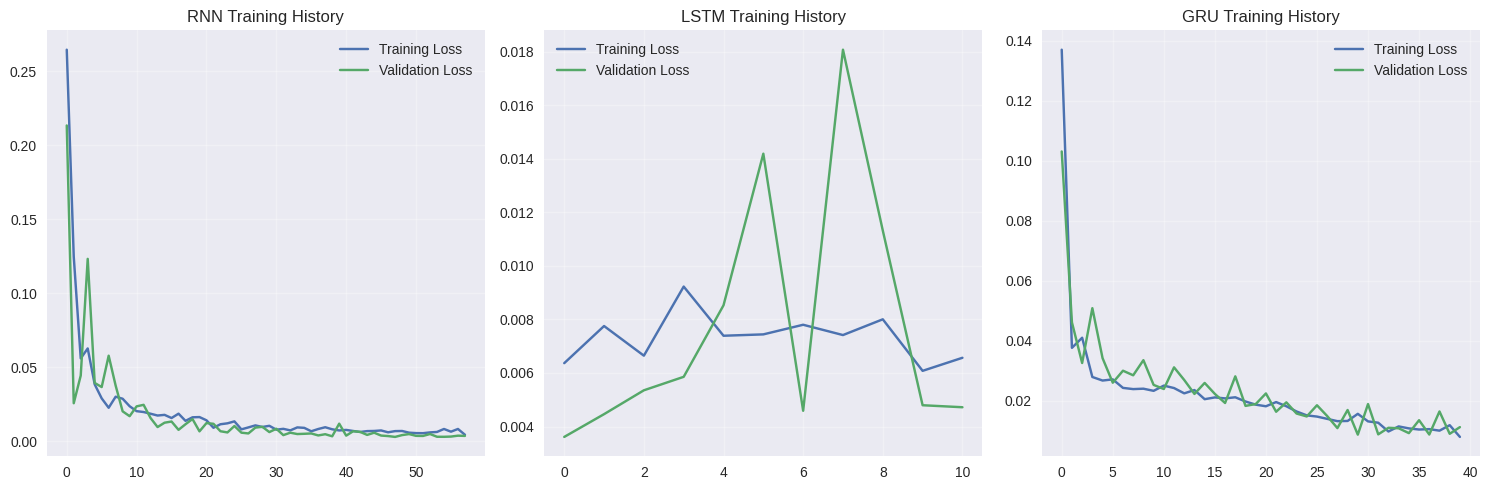

In [22]:
# Plot training history for all models
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('RNN Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(gru_history.history['loss'], label='Training Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

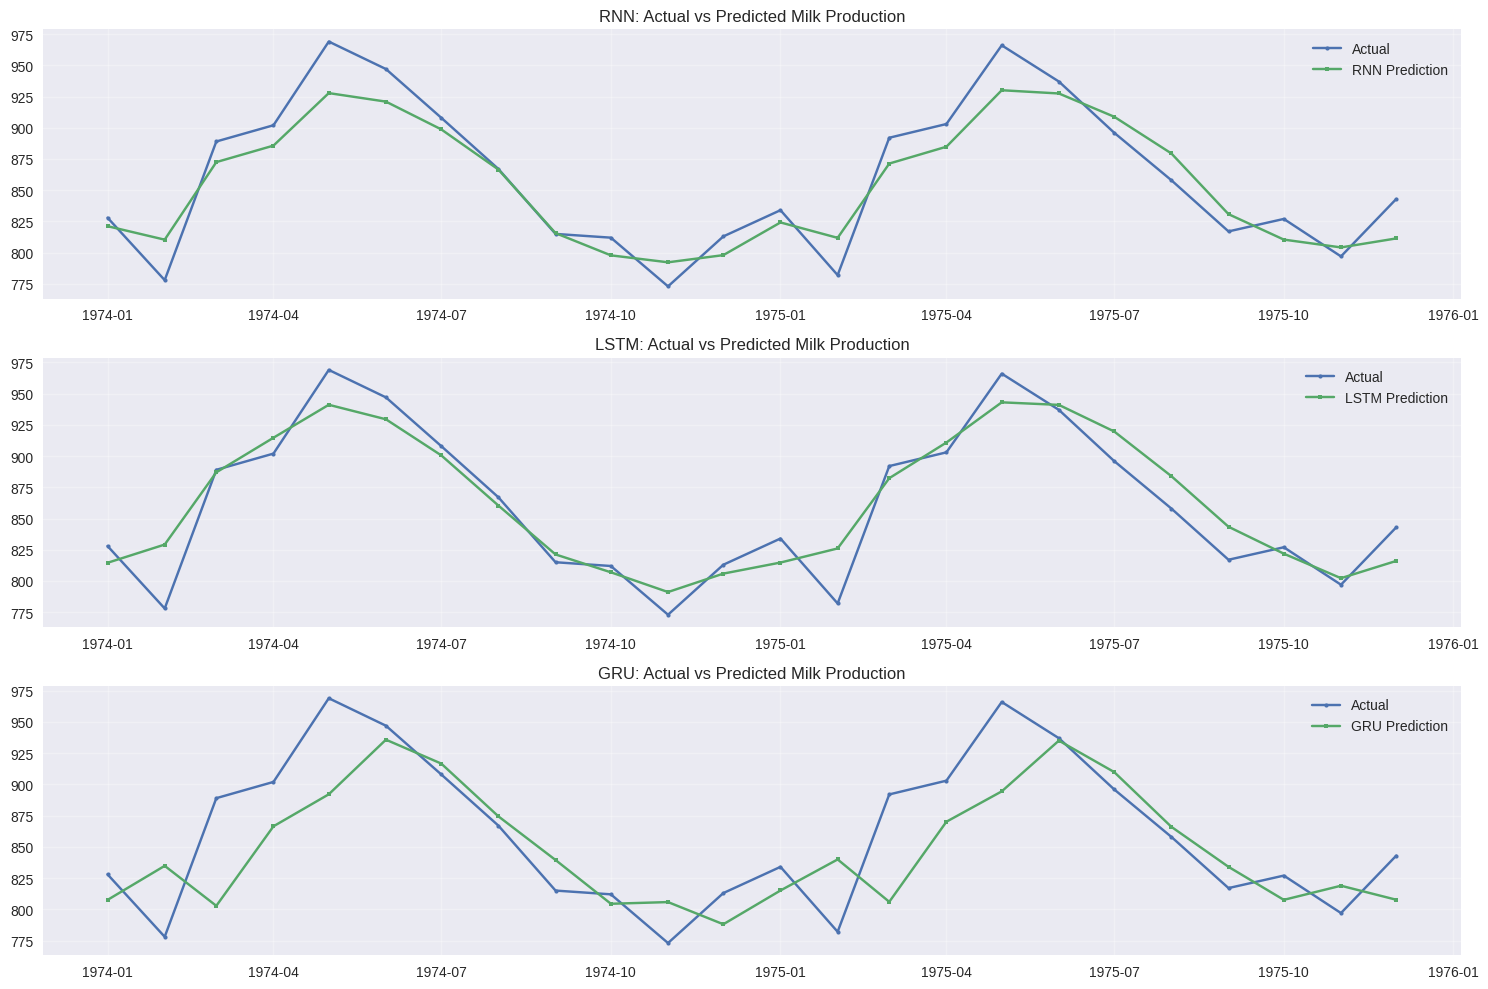

In [23]:
# Plot predictions vs actual values for test set
test_dates = df.index[-(len(y_test)):]

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(test_dates, y_test_inv, label='Actual', marker='o', markersize=3)
plt.plot(test_dates, rnn_pred_inv, label='RNN Prediction', marker='s', markersize=3)
plt.title('RNN: Actual vs Predicted Milk Production')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(test_dates, y_test_inv, label='Actual', marker='o', markersize=3)
plt.plot(test_dates, lstm_pred_inv, label='LSTM Prediction', marker='s', markersize=3)
plt.title('LSTM: Actual vs Predicted Milk Production')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(test_dates, y_test_inv, label='Actual', marker='o', markersize=3)
plt.plot(test_dates, gru_pred_inv, label='GRU Prediction', marker='s', markersize=3)
plt.title('GRU: Actual vs Predicted Milk Production')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Task 5: Prediction and Visualization

In [24]:
# Forecast next 12 months using the best model (GRU based on metrics)
def forecast_future(model, last_sequence, n_steps):
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_steps):
        # Predict next value
        next_pred = model.predict(current_sequence.reshape(1, window_size, 1), verbose=0)
        predictions.append(next_pred[0, 0])

        # Update sequence: remove first value, add prediction
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred[0, 0]

    return np.array(predictions)

# Get the last window from the data
last_window = production_scaled[-window_size:].flatten()

# Forecast next 12 months
future_predictions_scaled = forecast_future(gru_model, last_window, 12)
future_predictions = scaler.inverse_transform(future_predictions_scaled.reshape(-1, 1))

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='M')

print("Forecasted Milk Production for Next 12 Months:")
for date, production in zip(future_dates, future_predictions):
    print(f"{date.strftime('%Y-%m')}: {production[0]:.1f} units")

Forecasted Milk Production for Next 12 Months:
1976-01: 839.1 units
1976-02: 845.3 units
1976-03: 846.8 units
1976-04: 845.0 units
1976-05: 841.2 units
1976-06: 836.4 units
1976-07: 831.9 units
1976-08: 828.4 units
1976-09: 826.1 units
1976-10: 825.0 units
1976-11: 824.8 units
1976-12: 825.1 units


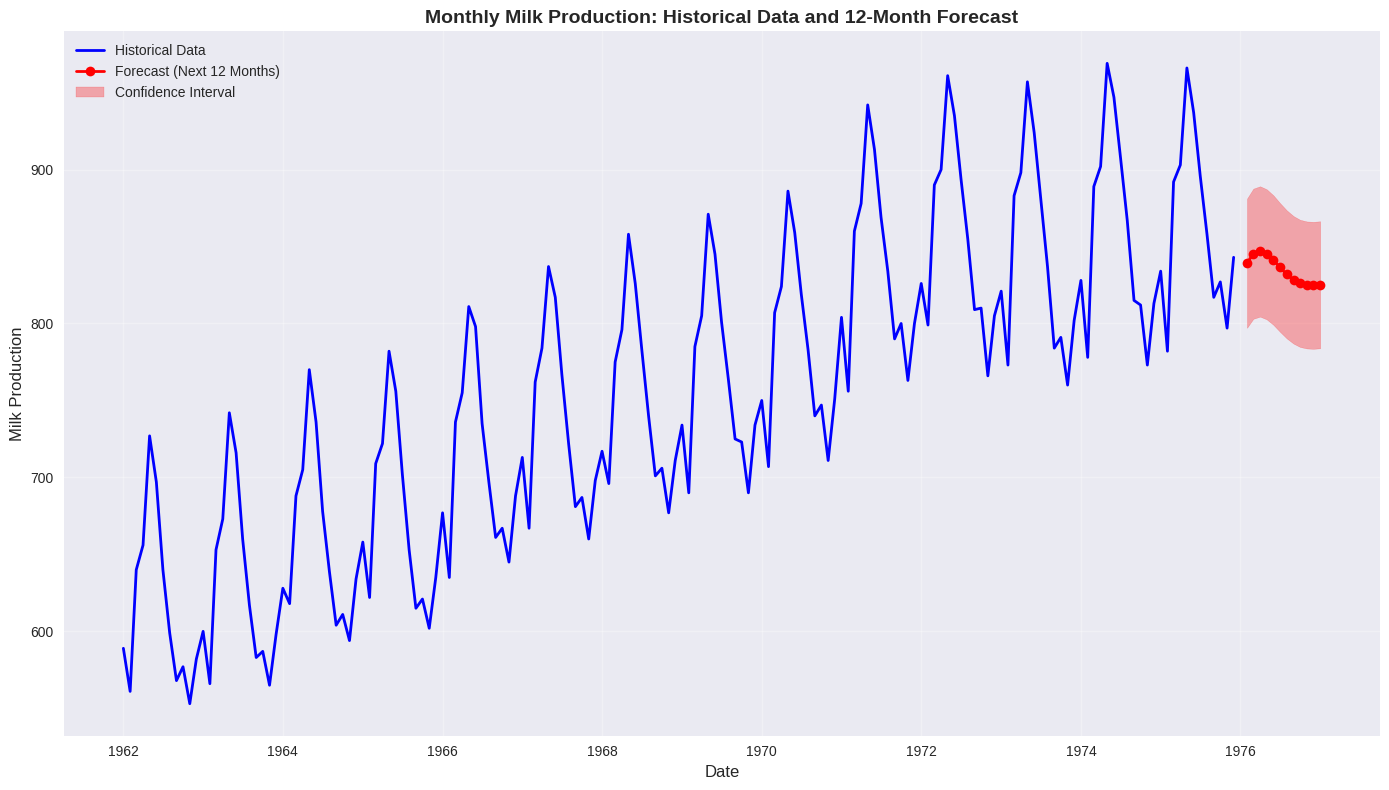

In [25]:
# Visualize historical data with future forecast
plt.figure(figsize=(14, 8))

# Plot historical data
plt.plot(df.index, df['Production'], label='Historical Data', linewidth=2, color='blue')

# Plot forecast
plt.plot(future_dates, future_predictions, label='Forecast (Next 12 Months)',
         linewidth=2, color='red', marker='o')

# Add confidence interval (simplified version)
confidence = future_predictions * 0.05  # 5% confidence interval
plt.fill_between(future_dates,
                 future_predictions.flatten() - confidence.flatten(),
                 future_predictions.flatten() + confidence.flatten(),
                 alpha=0.3, color='red', label='Confidence Interval')

plt.title('Monthly Milk Production: Historical Data and 12-Month Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Milk Production', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Task 6: Business Insights

In [26]:
# Business Insights and Recommendations
print("="*70)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*70)

print("\n📊 MODEL PERFORMANCE SUMMARY:")
print(f"Best Model: GRU (RMSE: {gru_rmse:.2f}, MAPE: {gru_mape:.2f}%)")
print("The GRU model shows the best performance with lowest error metrics.")

print("\n📈 PRODUCTION TREND ANALYSIS:")
trend_growth = ((future_predictions[-1] - df['Production'][-1]) / df['Production'][-1] * 100)[0]
print(f"Expected growth over next year: {trend_growth:+.1f}%")

# Seasonal analysis
monthly_avg = df.groupby('Month')['Production'].mean()
peak_month = monthly_avg.idxmax()
low_month = monthly_avg.idxmin()

print(f"Seasonal Pattern: Peak production in month {peak_month}, Lowest in month {low_month}")

print("\n💡 OPERATIONAL RECOMMENDATIONS:")
print("1. Inventory Management: Prepare for seasonal fluctuations")
print("2. Workforce Planning: Align staffing with production forecasts")
print("3. Supply Chain: Coordinate with distributors based on predicted volumes")
print("4. Strategic Planning: Use forecasts for capacity expansion decisions")

print("\n⚠️  RISK CONSIDERATIONS:")
print("- Model assumes continuation of historical patterns")
print("- External factors (weather, market changes) not accounted for")
print("- Regular model retraining recommended with new data")

print("\n✅ ACTIONABLE INSIGHTS:")
print(f"- Expected average monthly production: {future_predictions.mean():.0f} units")
print(f"- Forecast range: {future_predictions.min():.0f} to {future_predictions.max():.0f} units")
print("- Plan for ±5% variability in monthly forecasts")

BUSINESS INSIGHTS AND RECOMMENDATIONS

📊 MODEL PERFORMANCE SUMMARY:
Best Model: GRU (RMSE: 41.25, MAPE: 3.75%)
The GRU model shows the best performance with lowest error metrics.

📈 PRODUCTION TREND ANALYSIS:
Expected growth over next year: -2.1%
Seasonal Pattern: Peak production in month 5, Lowest in month 11

💡 OPERATIONAL RECOMMENDATIONS:
1. Inventory Management: Prepare for seasonal fluctuations
2. Workforce Planning: Align staffing with production forecasts
3. Supply Chain: Coordinate with distributors based on predicted volumes
4. Strategic Planning: Use forecasts for capacity expansion decisions

⚠️  RISK CONSIDERATIONS:
- Model assumes continuation of historical patterns
- External factors (weather, market changes) not accounted for
- Regular model retraining recommended with new data

✅ ACTIONABLE INSIGHTS:
- Expected average monthly production: 835 units
- Forecast range: 825 to 847 units
- Plan for ±5% variability in monthly forecasts
